In [1]:
import music21 as m21
import copy
import sys
import os
import time
#import pygame

import math
import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from collections import OrderedDict
import pickle

import pingouin as pg

In [2]:
# 'Masses_CompSeries_Mo_1058.pkl' # 20200324 complete run

# Definitions 

In [2]:
# new definitinos for processing streams that deal better with triple meter issues

def Onset_List(m21stream):
    # this function returns the timepoints of note onsets (in score time, beats)
    # reduced to a list of unique timepoints
    allOns = []
    # first: is this a score?   
    if isinstance(m21stream,m21.stream.Score):  
        # retreive all note onsets from score
        for p in m21stream:
            if isinstance(p,m21.stream.Part):
                ons = Onset_List(p)
                allOns.extend(ons)
    if isinstance(m21stream,m21.stream.Part):
        flattenedp = m21stream.flat.notesAndRests
        rest_state = 0
        tie_state = 0
        for el in flattenedp:
            if isinstance(el,m21.note.Note):
                rest_state = 0
                if el.tie:
                    if el.tie.type == 'start':
                        allOns.append(float(el.offset))
                else:
                    allOns.append(float(el.offset))
            if isinstance(el,m21.note.Rest):
                if rest_state == 0:
                    # allOns.append(float(el.offset)) # Do not include rest onsets
                    rest_state = 1
        allOns.append(float(el.offset+el.quarterLength)) # end of last note or rest     
    # extract unique time values
    ons = np.unique(allOns)
    return ons

def Diatonic_Number(note):
    # translates a music21 note element to it's number in diatonic values, 
    # instead of chromatic like midi
    diatonic = {'C':0,'D':1,'E':2,'F':3,'G':4,'A':5,'B':6}
    dPitch = diatonic[note.name[0]] + 7 + note.octave*7
    return dPitch

def Onset_Pitch_List(m21part):
    # this function returns the timepoints and pitch of note onsets (in score time, beats) for parts
    # counts notes only as their diatonic numbers, not midi chromatic values
    # forcing el.offset and el.quarterlength to floats for indexing purposes
    ons = [[],[]]
    # input must be a part
    if isinstance(m21part,m21.stream.Part):    
        # retreive all note onsets from score
        flattenedp = m21part.flat.notesAndRests
        rest_state = 0
        for el in flattenedp:
            if isinstance(el,m21.note.Note):
                rest_state = 0
                if el.tie:
                        if el.tie.type == 'start':
                            ons[0].append(float(el.offset))
                            #ons[1].append(el.pitch.ps)
                            ons[1].append(Diatonic_Number(el))
                else:
                    ons[0].append(float(el.offset))
                    #ons[1].append(el.pitch.ps)
                    ons[1].append(Diatonic_Number(el))
            if isinstance(el,m21.note.Rest):
                 if rest_state == 0:
                    ons[0].append(float(el.offset)) 
                    ons[1].append(math.nan)
                    rest_state = 1
        ons[0].append(float(el.offset+el.quarterLength))
        ons[1].append(math.nan)
    return ons

def beat_Times(score):
    # generate complete beatTimes list for interpolated pitch sequences and melodies
    onsAll = Onset_List(score)
    step = np.min(np.diff(onsAll))
    if np.min(np.diff(onsAll))<1:
        step = np.min([np.min(np.diff(onsAll)),1-np.min(np.diff(onsAll))])
    rate_options = [8,6,4,3,2,1,0.5,0.25,0.125] # heavy handed fix of the rates to covenient beat values
    close_rate =np.argmin(abs(rate_options -(1/step)))
    new_step = 1/rate_options[close_rate]
    beatTime = np.arange(onsAll[0],onsAll[-1]+new_step,new_step)
    return beatTime    

def Pitch_Beat_Interpolate(onsets,pitchValues,beatTime):
    # function to produce pitch sequence at times beatTime from onset list with corresponding pitch values
    # apparently this kind of interpolation isn't an option in pandas?!
    # first align min values
    if onsets[0]>beatTime[0]:
        onsets = beatTime[0] + onsets
        pitchValues = math.nan + pitchValues
    beatTime_pitch = np.array(np.zeros_like(beatTime), dtype=np.float)
    onsets_h = np.array(onsets)
    for i_beats in range(len(beatTime)):
        r = np.max(np.where(onsets_h<=beatTime[i_beats]))
        beatTime_pitch[i_beats] = pitchValues[np.max(np.where(onsets_h<=beatTime[i_beats]))]
    return beatTime_pitch

def Score_Pitch_Steps(score):
    # from an m21 score, evaluate the pitch squence in each part and outputs
    # panda dataframe with colums of current pitch values for even sampling (on smallest subdivision)
    df_Score = pd.DataFrame()
    if isinstance(score,m21.stream.Score):  
        beatTime = beat_Times(score)
        df_Score = pd.DataFrame(index=beatTime)
        #df_Score['time'] = beatTime 
        #then run through all parts to first extract onsets and then build sequence
        k = 1
        for part in score:
            if isinstance(part,m21.stream.Part):
                if part.partName is None:
                    pn = 'Voice_' +str(k)
                    k+=1
                else:
                    pn = part.partName.strip('"')
                    if pn.startswith('Voice'):
                        pn = 'Voice_' +str(k)
                        k+=1
                onsets = Onset_Pitch_List(part)
                df_Score[pn] = Pitch_Beat_Interpolate(onsets[0],onsets[1],beatTime)
    return df_Score

def Comp_Decay(series,beat_decay_slope):
    # Assume evenly sampled index of series
    A = series.fillna(0)
    B = series
    step = np.min(np.diff(series.index))
    # ar values
    ar = -(beat_decay_slope*step)*np.arange(0,1./beat_decay_slope,step)
    # smoothing without negatives
    for i in range(len(ar)):
        shifted = B.shift(periods=i+1,fill_value=0) + ar[i]
        shifted = shifted.mask(shifted<0,0)
        A += shifted.fillna(0)
        #A = A.mask(A<0,0)
    return A

def Onset_Cues(score):
    beatTime = beat_Times(score)
    df_Score = pd.DataFrame(index=beatTime)
    k = 1
    for part in score:
        if isinstance(part,m21.stream.Part):
            pn = 'Voice_' + str(k)
            df_Score[pn] = Event_Beat_Interpolate(Onset_List(part),beatTime)
            k+=1
    df_seperate = df_Score.fillna(0)
    return df_seperate

def Motion_Cues(score):
    # cues to blend: co entry (++), co-onsets, co-direction (comodulation)
    # count up from bass, who shares with them?
    df_pitchs = Score_Pitch_Steps(score)
    beatwise = df_pitchs
    beatwise = beatwise.fillna(-25) # CHEAT to catch entries, assuming here no voice leaps more than two octaves
    beatwise = beatwise.diff()
    beatwise = beatwise.mask(beatwise>25,math.nan) # Mark entries with nan(cheat)
    beatwise = beatwise.mask(beatwise<-25,0) # ignore ends of lines 
    beatwise = beatwise.mask(beatwise>0,1) # equate all increases
    beatwise = beatwise.mask(beatwise<0,-1) # equate all decreases
    beatwise = beatwise.fillna(0) # remove entries by replacing nan with 0 
    beatwise = beatwise.mask(df_pitchs.isna(),math.nan) # reapply nan values where voices are quiet
    df_seperate = beatwise

    #returned columns of voice seperationg actions, with coaction attributed to highest active voice. Entries 1, other actions contribute 0.5
    # note: onsets counted only if with melodic motion.
    return df_seperate

def Entry_Cues(score):
    # cues to blend: co entry (++), co-onsets, co-direction (comodulation)
    # count up from bass, who shares with them?
    df_pitchs = Score_Pitch_Steps(score)
    beatwise = df_pitchs
    beatwise = beatwise.fillna(-25) # CHEAT to catch entries, assuming here no voice leaps more than two octaves
    beatwise = beatwise.diff()
    beatwise = beatwise.mask(beatwise>25,math.nan) # Mark entries with nan(cheat)
    beatwise = beatwise.mask(beatwise<20,0) # ignore ends of lines (cheat)
    beatwise = beatwise.fillna(2) # Distinguish entries by replacing nan with a higher values than changes in pitch
    beatwise = beatwise.mask(df_pitchs.isna(),math.nan) # reapply nan values where voices are quiet
    df_seperate = 0.5*beatwise
    #returned columns of voice seperationg actions, with coaction attributed to highest active voice. Entries 1, other actions contribute 0.5
    # note: onsets counted only if with melodic motion.
    return df_seperate

def Cue_Reduction(df_C):
    # for each voice, if voice seperation cues match those of a higher voice(s), make NA
    # or rather subtractive counting of independent streams, allowing for two or more voices per stream
    df_seperate = pd.DataFrame(index=df_C.index)
    parts = df_C.columns
    for i in range(len(parts)):
        df_seperate[parts[i]] = df_C[parts[i]]
    for i in range(len(parts)-1):
        for j in range(i+1,len(parts)):
            df_seperate[parts[j]] = df_seperate[parts[j]].mask(df_seperate[parts[j]]==df_seperate[parts[i]],math.nan)
    #df_seperate = 0.5*df_seperate.abs()
    df_seperate = df_seperate.fillna(0)
    return df_seperate

def Streaming(score):
    # TODO check if it is a score (m21 datatype) with multiple parts
    
    # calculate the streaming effect of this combination of cues 
    # Onsets
    df_C = Onset_Cues(score)
    df_seperate = Cue_Reduction(df_C)
    
    # add Pitch changes (with a reduction to remove reduncancy with onsets)
    df_C = Motion_Cues(score)
    df_seperate = df_seperate.mask(df_C.abs()>0,0)
    df_seperate = 0.25*df_seperate + 0.5*Cue_Reduction(df_C).abs()

    # Entries (with a reduction to removed redundancies with onsets)
    df_C = Entry_Cues(score)
    df_seperate = Cue_Reduction(df_C) + df_seperate # entries get twice the weight as other cues
    df_seperate = df_seperate.mask(df_seperate>1,1)

    # integrate successive cues and allow them decay time
    df_streams = Comp_Decay(df_seperate,0.2) # reduction linear over 4 steps
    df_streams = df_streams.mask(df_streams>1,1) # capt contributions per stream
    
    # find min streams WITH 1 held line if present
    
    df_sounds = Score_Pitch_Steps(score)       
    # B this series knows where the voices are silent. OK
    df_B = df_sounds.mask(df_sounds.isna(),0)
    B = df_B.sum(1)
    B =  B.mask(B==0,math.nan) 
    
    df_sounds = df_sounds.mask(df_sounds>1,0) # all times sounding is zero. 
    df_sounds += df_streams # add all the cues
    parts = df_sounds.columns 
    for i in range(len(parts)-1): # reduce the shared held parts to highest voice
        for j in range(i+1,len(parts)):
            df_sounds[parts[j]] = df_sounds[parts[j]].mask(df_sounds[parts[j]]==df_sounds[parts[i]],math.nan)
    # now all the zeros are the top held voice, but the cues are messed up
    df_sounds = df_sounds.mask(df_sounds>0,math.nan) # remove remaining cues
    df_sounds = df_sounds.mask(df_sounds==0,2) # isolate held lines above
    df_sounds = df_sounds.mask(df_sounds.isna(),0) # set
    df_sounds += df_streams # now the min voices are active, cues and held
    df_sounds = df_sounds.mask(df_sounds==0,math.nan) # remove the extraneous zeros
    df_streams = df_sounds.mask(df_sounds==2,0.25) # held notes are given some value but not a full stream

    C = df_streams.sum(1) - df_streams.max(1) + 1 # replace most active "distinct" voice with 1

    C = C.mask(C<1,1)
    C = C.mask(B.isna(),math.nan)
    df_streams['Total'] = C
    
    return df_streams


# now for onset only measure of seperation
def Event_Beat_Interpolate(events,beatTime):
    # fit onset list into beatTime sequence
    beatTime_es = np.array(np.zeros_like(beatTime), dtype=np.float)
    beatTime_es.fill(np.nan)
    for es in events:
        i = np.max(np.where(beatTime<=es))
        beatTime_es[i] = 1
    return beatTime_es

def Voice_Count(score):
    df_pitch = Score_Pitch_Steps(score)
    # get the number of voices active per moment 
    df_pitch = df_pitch.mask(df_pitch>1,1)
    df_pitch = Comp_Decay(df_pitch,0.2)
    df_pitch = df_pitch.mask(df_pitch>1,1)
    df_pitch = df_pitch.mask(df_pitch.isna(),0)
    df_active = df_pitch.sum(1)
    return df_active

def Distribution_Functions(A):
    # A is a single column pandas series
    # output pandas series with column 1: df, column 2: cdf
    # get cdf of total 
    Fcnt = Counter()
    for c in A:
        r=np.around(c,2)
        Fcnt[r]+=1
    dist_values = sorted(list(OrderedDict.fromkeys(np.around(A,2))))
    cdf_A = pd.DataFrame(index=dist_values)
    B = []
    C = []
    L = float(len(A))
    for i in range(len(dist_values)):
        B.append(Fcnt[dist_values[i]]/L)
        C.append(np.sum(B))
    cdf_A['df'] = B
    cdf_A['cdf'] = C
    return cdf_A

In [3]:
os.chdir('/Users/finn/Documents/DDMAL/Scores/masses_all')
files = os.listdir()
files = sorted(files)
f = files[26]
print(f)

Ano1026b-Missa_Gross_senen-Gloria.krn


# Test eval

# Run Masses

In [5]:
Counterpoint_seperated = []
Voices_counted = []
df=pd.DataFrame(columns=['Mass','MassID','Mvnt','MvntN','Composer','CompID','file'])
massNames = []

os.chdir('/Users/finn/Documents/DDMAL/Scores/masses_all')
files = os.listdir()
files = sorted(files)
tic = time.time()

# composer mapping 
composer_map = OrderedDict()
composer_map = {'Agr':'Alexander Agricola','Ano':'Anonymus','Bru':'Antione Brumel','Bus':'Antoine Busnoys','Das':'Ludwig Daser','Duf':'Guillaume Du Fay','Fva':'Antoine de Fevin','Jos':'Josquin des Prez','Mar':'Johannes Martini','Obr':'Obrecht','Ock':'Johannes Ockeghem','Ort':'Marbrianus de Orto','Pip':'Pipelare','Rue':'Pierre de la Rue','Tin':'Johannes Tinctoris','Unj':'Unverified Josquin'}
masses_unv_Jos = ['Jos0302','Jos0304','Jos0401','Jos0404','Jos0405','Jos0406','Jos0501','Jos0502','Jos0601','Jos0602','Jos0701','Jos0902','Jos0903','Jos0904','Jos1001','Jos1002','Jos1003','Jos1201']
movement_No = 1

for f in files:
    if f.endswith('krn'):
        a = f.split('-')
        m_id = a[0][:7]
        c_id = a[0][:3]
        if m_id in masses_unv_Jos: c_id = 'Unj'      
        mass_name = a[1]
        endbit = a[-1].split('.')
        a[-1] = endbit[0]
        movement = a[2]
        if len(a)>3: mass_name += '-' + a[-1]
        if not mass_name in massNames: massNames.append(mass_name)
        score = m21.converter.parse(f)
        # onsets and countpoint
        df_seperated = Streaming(score)
        Counterpoint_seperated.append(df_seperated['Total'])
        # onsets
        Voices_counted.append(Voice_Count(score))
            
        df = df.append({'Mass':mass_name,'MassID':m_id,'Mvnt':movement,'MvntN':movement_No,'Composer':composer_map[c_id],'CompID':c_id,'file':f},ignore_index=True)

        toc = time.time()
        print(str(toc-tic) + 's ' + m_id + ': ' + movement + ' ' + str(movement_No))
        
print(len(df))
print(len(massNames))


8.459560871124268s Agr1001: Gloria 1
15.833706855773926s Agr1001: Credo 1
22.98629879951477s Agr1001: Sanctus 1
28.430699586868286s Agr1001: Agnus 1
30.42568278312683s Agr1004: Kyrie 1
35.06510782241821s Agr1004: Gloria 1
40.30391764640808s Agr1004: Credo 1
44.06545162200928s Agr1004: Sanctus 1
46.906797647476196s Agr1004: Agnus 1
47.906569957733154s Ano1001: Kyrie 1
49.36111378669739s Ano1001: Gloria 1
51.47256779670715s Ano1001: Credo 1
53.59629678726196s Ano1001: Sanctus 1
54.385597944259644s Ano1001: Agnus 1
56.7979257106781s Ano1025: Kyrie 1
65.3312418460846s Ano1025: Gloria 1
76.5702977180481s Ano1025: Credo 1
82.06740880012512s Ano1025: Sanctus 1
86.6833348274231s Ano1025: Agnus 1
92.89310574531555s Ano1026: Kyrie 1
99.83465480804443s Ano1026: Gloria 1
115.07639288902283s Ano1026: Credo 1
128.0306417942047s Ano1026: Sanctus 1
132.71048188209534s Ano1026: Agnus 1
133.94799780845642s Bus1001: Kyrie 1
136.7719476222992s Bus1001: Gloria 1
140.99715876579285s Bus1001: Credo 1
144.495

716.3932867050171s Mar1004: Sanctus 1
717.636640548706s Mar1004: Agnus 1
718.2933986186981s Mar1006: Kyrie 1
721.0292196273804s Mar1006: Sanctus 1
723.8399157524109s Mar1006: Agnus 1
724.1942517757416s Mar1007: Kyrie 1
724.790474653244s Mar1007: Gloria 1
725.9906847476959s Mar1007: Credo 1
727.3706097602844s Mar1007: Sanctus 1
727.7778878211975s Mar1007: Agnus 1
729.5268898010254s Mar1009: Kyrie 1
732.6789917945862s Mar1009: Gloria 1
737.3913159370422s Mar1009: Credo 1
740.5727119445801s Mar1009: Sanctus 1
742.6242728233337s Mar1009: Agnus 1
743.2952628135681s Mar1010: Kyrie 1
745.1489436626434s Mar1010: Gloria 1
747.42982172966s Mar1010: Credo 1
748.7508397102356s Mar1010: Sanctus 1
749.6453237533569s Mar1010: Agnus 1
751.0294406414032s Obr1001: Kyrie 1
753.7349336147308s Obr1001: Gloria 1
756.6063475608826s Obr1001: Credo 1
758.9872698783875s Obr1001: Sanctus 1
760.1271739006042s Obr1001: Agnus 1
761.5085098743439s Obr1002: Kyrie 1
765.0814399719238s Obr1002: Gloria 1
769.98571968078

humdrum.spineParser: WARNING: Error in parsing event ('*M') at position 830 for spine None: Incorrect meter: *M found


1083.8749396800995s Rue1011: Gloria 1
1087.9403088092804s Rue1011: Credo 1
1091.6100957393646s Rue1011: Sanctus 1
1094.010286808014s Rue1011: Agnus 1
1095.456033706665s Rue1012: Kyrie 1
1097.6937296390533s Rue1012: Gloria 1
1100.9384667873383s Rue1012: Credo 1
1103.5018796920776s Rue1012: Sanctus 1
1104.8027656078339s Rue1012: Agnus 1
1106.07119679451s Rue1013: Kyrie 1
1108.4009909629822s Rue1013: Gloria 1
1111.2052175998688s Rue1013: Credo 1
1112.8216967582703s Rue1013: Sanctus 1
1114.3266768455505s Rue1013: Agnus 1
1116.0116407871246s Rue1014: Kyrie 1
1120.1595866680145s Rue1014: Gloria 1
1125.3262479305267s Rue1014: Credo 1
1128.2919585704803s Rue1014: Sanctus 1
1130.5668227672577s Rue1014: Agnus 1
1131.7171845436096s Rue1015: Kyrie 1
1133.7494809627533s Rue1015: Gloria 1
1136.8670318126678s Rue1015: Credo 1
1139.4291877746582s Rue1015: Sanctus 1
1140.7716128826141s Rue1015: Agnus 1
1142.283493757248s Rue1016: Kyrie 1
1145.52951669693s Rue1016: Gloria 1
1150.0720756053925s Rue1016: 

In [6]:
print(len(Counterpoint_seperated))
print(len(Voices_counted))
df

467
467


,Mass,MassID,Mvnt,MvntN,Composer,CompID,file
0,Missa_In_myne_zin,Agr1001,Gloria,1,Alexander Agricola,Agr,Agr1001a-Missa_In_myne_zin-Gloria.krn
1,Missa_In_myne_zin,Agr1001,Credo,1,Alexander Agricola,Agr,Agr1001b-Missa_In_myne_zin-Credo.krn
2,Missa_In_myne_zin,Agr1001,Sanctus,1,Alexander Agricola,Agr,Agr1001c-Missa_In_myne_zin-Sanctus.krn
3,Missa_In_myne_zin,Agr1001,Agnus,1,Alexander Agricola,Agr,Agr1001d-Missa_In_myne_zin-Agnus.krn
4,Missa_Malheur_me_bat,Agr1004,Kyrie,1,Alexander Agricola,Agr,Agr1004a-Missa_Malheur_me_bat-Kyrie.krn
...,...,...,...,...,...,...,...
462,Missa_Sine_nomine_I,Tin1002,Kyrie,1,Johannes Tinctoris,Tin,Tin1002a-Missa_Sine_nomine_I-Kyrie.krn
463,Missa_Sine_nomine_I,Tin1002,Gloria,1,Johannes Tinctoris,Tin,Tin1002b-Missa_Sine_nomine_I-Gloria.krn
464,Missa_Sine_nomine_I,Tin1002,Credo,1,Johannes Tinctoris,Tin,Tin1002c-Missa_Sine_nomine_I-Credo.krn
465,Missa_Sine_nomine_I,Tin1002,Sanctus,1,Johannes Tinctoris,Tin,Tin1002d-Missa_Sine_nomine_I-Sanctus.krn


In [7]:
# save these results from the last above cell
os.chdir('/Users/finn/Documents/DDMAL/Scores')
Series_Complexities={'MusicIndex':df,'Streaming_Complexity':Counterpoint_seperated,'Voice_Counts':Voices_counted}
f=open('Masses_CompSeries_Stream3_1.pkl','wb')
pickle.dump(Series_Complexities,f,-1)
f.close()

In [8]:
# retreive the last round of evaluations

os.chdir('/Users/finn/Documents/DDMAL/Scores')
f=open('Masses_CompSeries_Stream3_1.pkl','rb')
S_Complexities=pickle.load(f)
f.close()

df = S_Complexities['MusicIndex']
Counterpoint_seperated = S_Complexities['Streaming_Complexity']
Voices_counted = S_Complexities['Voice_Counts']

os.chdir('/Users/finn/Documents/DDMAL/Scores/masses_all')


In [9]:
os.chdir('/Users/finn/Documents/DDMAL/Scores/masses_all/Palestrina/')

files = os.listdir()
files = sorted(files)

mvmt = ['Kyrie','Gloria','Credo','Sanctus','Agnus']
massNames = []

composer = 'Giovanni Pierluigi da Palestrina'
c_id = 'Pal'
tic = time.time()

appended = True

for i in range(len(files)):
    f = files[i]
    if f.endswith('mid'):
        movement_No = 1
        a = f.split('_')
        appendprevious = False
        appendnext = False
        
        if a[-2].startswith('I'):
            movement = a[-3]
            mass_name = 'Missa_'+'_'.join(a[:-3])
            
            if a[-2] == 'II':  # should it append a previous file or a following 
                if abs(len(files[i-1])-len(f))<4:
                    if files[i-1][:len(f)-8] ==f[:len(f)-8]:
                        appendprevious = True
                        print('      this:' + f)
                        print('      last:' + files[i-1])
                if abs(len(files[i+1])-len(f))<4:        
                    if files[i+1][:len(f)-8] == f[:len(f)-8]:
                        appendprevious = False
                        appendnext = True
                        appended = False
                        f_II = f
                        print('      this:' + f)
                        print('      next:' + files[i+1])
        else: 
            movement = a[-2]
            mass_name = 'Missa_'+'_'.join(a[:-2])
        
        if not mass_name in massNames:
                massNames.append(mass_name)    
        m_id = c_id + str(1000 + len(massNames))
        
        
        if movement.startswith('Bene') or appendnext: # skip this file and return later
            if movement.startswith('Bene'):
                b_f = f
                b_mass = mass_name
                b_move = movement
            print('holding off eval on ' + f)
        else:

            if appendprevious:  
                score = m21.converter.parse(f) 
                # Eval streaming on this last bit, shift index and add to that final stream
                df_seperated = Streaming(score)
                df_seperated['Total'].index = df_seperated['Total'].index + max(Counterpoint_seperated[-1].index) + 2
                Counterpoint_seperated[-1] = Counterpoint_seperated[-1].append(df_seperated['Total'])

                df_seperated = Voice_Count(score)
                df_seperated.index = df_seperated.index + max(Voices_counted[-1].index) + 2
                Voices_counted[-1] = Voices_counted[-1].append(df_seperated)

                movement_No = 2
                df.iloc[-1,df.columns.get_loc('MvntN')] = movement_No 
                appendprevious = False
                toc = time.time()
                print(str(toc-tic) + 's ' + m_id + ': ' + movement + ' ' + str(movement_No))
                print('Appended ' + f + 'to previous movement ' + df.iloc[-1,df.columns.get_loc('Mvnt')])
                
            else: 
                score = m21.converter.parse(f)
                # onsets and countpoint
                df_seperated = Streaming(score)
                Counterpoint_seperated.append(df_seperated['Total'])
                # voices active
                df_seperated = Voice_Count(score)
                Voices_counted.append(df_seperated)
                toc = time.time()
                print(str(toc-tic) + 's ' + m_id + ': ' + movement + ' ' + str(movement_No))

                if movement == 'Sanctus':
                    if mass_name == b_mass: # eval and append benedictus
                        print('Found ' + f + ' for ' + b_f)
                        score = m21.converter.parse(b_f) 
                        # Eval streaming on this last bit, shift index and add to that final stream
                        df_seperated = Streaming(score)
                        df_seperated['Total'].index = df_seperated['Total'].index + max(Counterpoint_seperated[-1].index) + 2
                        Counterpoint_seperated[-1] = Counterpoint_seperated[-1].append(df_seperated['Total'])

                        df_seperated = Voice_Count(score)
                        df_seperated.index = df_seperated.index + max(Voices_counted[-1].index) + 2
                        Voices_counted[-1] = Voices_counted[-1].append(df_seperated)
                        movement_No = 2
                        toc = time.time()
                        print(str(toc-tic) + 's ' + m_id + ': ' + movement + ' ' + str(movement_No))
                
                if not appended:
                        print('Found ' + f + ' for ' + f_II)
                        score = m21.converter.parse(f_II) 
                        # Eval streaming on this last bit, shift index and add to that final stream
                        df_seperated = Streaming(score)
                        df_seperated['Total'].index = df_seperated['Total'].index + max(Counterpoint_seperated[-1].index) + 2
                        Counterpoint_seperated[-1] = Counterpoint_seperated[-1].append(df_seperated['Total'])

                        df_seperated = Voice_Count(score)
                        df_seperated.index = df_seperated.index + max(Voices_counted[-1].index) + 2
                        Voices_counted[-1] = Voices_counted[-1].append(df_seperated)
                        movement_No = 2
                        appended = True
                        toc = time.time()
                        print(str(toc-tic) + 's ' + m_id + ': ' + movement + ' ' + str(movement_No))
                df = df.append({'Mass':mass_name,'MassID':m_id,'Mvnt':movement,'MvntN':movement_No,'Composer':composer,'CompID':c_id,'file':f},ignore_index=True)
#                 toc = time.time()
#                 print(str(toc-tic) + 's ' + m_id + ': ' + movement + ' ' + str(movement_No))

            
        
print(len(df))
print(len(Counterpoint_seperated))
print(len(Voices_counted))
print(len(massNames))




      this:Ad_coenam_Agni_Agnus_II_6.mid
      next:Ad_coenam_Agni_Agnus_I_5.mid
holding off eval on Ad_coenam_Agni_Agnus_II_6.mid
0.7546639442443848s Pal1001: Agnus 1
Found Ad_coenam_Agni_Agnus_I_5.mid for Ad_coenam_Agni_Agnus_II_6.mid
1.9343829154968262s Pal1001: Agnus 2
holding off eval on Ad_coenam_Agni_Benedictus_5.mid
5.705517053604126s Pal1001: Credo 1
8.018588781356812s Pal1001: Gloria 1
8.602807760238647s Pal1001: Kyrie 1
      this:Ad_coenam_Agni_Kyrie_II_5.mid
      last:Ad_coenam_Agni_Kyrie_5.mid
9.155387878417969s Pal1001: Kyrie 2
Appended Ad_coenam_Agni_Kyrie_II_5.midto previous movement Kyrie
10.772773742675781s Pal1001: Sanctus 1
Found Ad_coenam_Agni_Sanctus_5.mid for Ad_coenam_Agni_Benedictus_5.mid
11.705187797546387s Pal1001: Sanctus 2
      this:Ad_fugam_Agnus_II_5.mid
      next:Ad_fugam_Agnus_I_4.mid
holding off eval on Ad_fugam_Agnus_II_5.mid
12.255383729934692s Pal1002: Agnus 1
Found Ad_fugam_Agnus_I_4.mid for Ad_fugam_Agnus_II_5.mid
13.088507890701294s Pal1002: 

116.76212286949158s Pal1013: Credo 1
117.81250309944153s Pal1013: Gloria 1
118.59688782691956s Pal1013: Kyrie 1
119.3836658000946s Pal1013: Sanctus 1
Found Brevis_Sanctus_4.mid for Brevis_Benedictus_4.mid
120.04852771759033s Pal1013: Sanctus 2
      this:Confitebor_tibi_Agnus_II_8.mid
      next:Confitebor_tibi_Agnus_I_8.mid
holding off eval on Confitebor_tibi_Agnus_II_8.mid
121.27312994003296s Pal1014: Agnus 1
Found Confitebor_tibi_Agnus_I_8.mid for Confitebor_tibi_Agnus_II_8.mid
122.40245079994202s Pal1014: Agnus 2
holding off eval on Confitebor_tibi_Benedictus_8.mid
127.44634866714478s Pal1014: Credo 1
130.57359099388123s Pal1014: Gloria 1
132.27373886108398s Pal1014: Kyrie 1
      this:Confitebor_tibi_Kyrie_II_8.mid
      last:Confitebor_tibi_Kyrie_8.mid
133.30931687355042s Pal1014: Kyrie 2
Appended Confitebor_tibi_Kyrie_II_8.midto previous movement Kyrie
135.6766757965088s Pal1014: Sanctus 1
Found Confitebor_tibi_Sanctus_8.mid for Confitebor_tibi_Benedictus_8.mid
136.5392799377441

233.054340839386s Pal1027: Agnus 2
holding off eval on Ecce_sacerdos_magnus_Benedictus_4.mid
235.9977307319641s Pal1027: Credo 1
237.74406385421753s Pal1027: Gloria 1
238.8225758075714s Pal1027: Kyrie 1
240.38382577896118s Pal1027: Sanctus 1
Found Ecce_sacerdos_magnus_Sanctus_4.mid for Ecce_sacerdos_magnus_Benedictus_4.mid
241.48573684692383s Pal1027: Sanctus 2
      this:Emendemus_in_melius_Agnus_II_5.mid
      next:Emendemus_in_melius_Agnus_I_4.mid
holding off eval on Emendemus_in_melius_Agnus_II_5.mid
242.07057189941406s Pal1028: Agnus 1
Found Emendemus_in_melius_Agnus_I_4.mid for Emendemus_in_melius_Agnus_II_5.mid
242.61326789855957s Pal1028: Agnus 2
holding off eval on Emendemus_in_melius_Benedictus_4.mid
244.22202706336975s Pal1028: Credo 1
245.55204510688782s Pal1028: Gloria 1
246.1941478252411s Pal1028: Kyrie 1
246.8566858768463s Pal1028: Sanctus 1
Found Emendemus_in_melius_Sanctus_4.mid for Emendemus_in_melius_Benedictus_4.mid
247.64596676826477s Pal1028: Sanctus 2
      this:

380.5699248313904s Pal1043: Credo 1
382.2520639896393s Pal1043: Gloria 1
383.3315908908844s Pal1043: Kyrie 1
384.75423097610474s Pal1043: Sanctus 1
Found In_semiduplx_majx_(II)_Sanctus_5.mid for In_semiduplx_majx_(II)_Benedictus_5.mid
385.64378690719604s Pal1043: Sanctus 2
      this:In_te_Domine_speravi_(1593-4)_Agnus_II_5.mid
      next:In_te_Domine_speravi_(1593-4)_Agnus_I_4.mid
holding off eval on In_te_Domine_speravi_(1593-4)_Agnus_II_5.mid
386.395281791687s Pal1044: Agnus 1
Found In_te_Domine_speravi_(1593-4)_Agnus_I_4.mid for In_te_Domine_speravi_(1593-4)_Agnus_II_5.mid
387.1536908149719s Pal1044: Agnus 2
holding off eval on In_te_Domine_speravi_(1593-4)_Benedictus_4.mid
389.40678095817566s Pal1044: Credo 1
390.89015197753906s Pal1044: Gloria 1
391.66570806503296s Pal1044: Kyrie 1
392.51602578163147s Pal1044: Sanctus 1
Found In_te_Domine_speravi_(1593-4)_Sanctus_4.mid for In_te_Domine_speravi_(1593-4)_Benedictus_4.mid
393.2677628993988s Pal1044: Sanctus 2
      this:In_te_Domine

482.1616668701172s Pal1056: Agnus 1
holding off eval on Memor_esto_Benedictus_5.mid
484.8160357475281s Pal1056: Credo 1
486.7665138244629s Pal1056: Gloria 1
487.6737759113312s Pal1056: Kyrie 1
488.5405578613281s Pal1056: Sanctus 1
Found Memor_esto_Sanctus_5.mid for Memor_esto_Benedictus_5.mid
489.54748582839966s Pal1056: Sanctus 2
      this:Nasce_la_gioia_mia_Agnus_II_6.mid
      next:Nasce_la_gioia_mia_Agnus_I_6.mid
holding off eval on Nasce_la_gioia_mia_Agnus_II_6.mid
490.3269350528717s Pal1057: Agnus 1
Found Nasce_la_gioia_mia_Agnus_I_6.mid for Nasce_la_gioia_mia_Agnus_II_6.mid
490.9926838874817s Pal1057: Agnus 2
holding off eval on Nasce_la_gioia_mia_Benedictus_6.mid
493.93831181526184s Pal1057: Credo 1
495.8532280921936s Pal1057: Gloria 1
496.52549290657043s Pal1057: Kyrie 1
      this:Nasce_la_gioia_mia_Kyrie_II_6.mid
      last:Nasce_la_gioia_mia_Kyrie_6.mid
497.24810910224915s Pal1057: Kyrie 2
Appended Nasce_la_gioia_mia_Kyrie_II_6.midto previous movement Kyrie
498.11270880699

610.0852637290955s Pal1070: Agnus 1
Found Petra_sancta_Agnus_I_5.mid for Petra_sancta_Agnus_II_6.mid
610.9119818210602s Pal1070: Agnus 2
holding off eval on Petra_sancta_Benedictus_5.mid
614.0820369720459s Pal1070: Credo 1
616.1363949775696s Pal1070: Gloria 1
617.2131540775299s Pal1070: Kyrie 1
618.215982913971s Pal1070: Sanctus 1
Found Petra_sancta_Sanctus_5.mid for Petra_sancta_Benedictus_5.mid
619.2123210430145s Pal1070: Sanctus 2
      this:Primi_toni_Agnus_II_5.mid
      next:Primi_toni_Agnus_I_4.mid
holding off eval on Primi_toni_Agnus_II_5.mid
619.8893897533417s Pal1071: Agnus 1
Found Primi_toni_Agnus_I_4.mid for Primi_toni_Agnus_II_5.mid
620.7000908851624s Pal1071: Agnus 2
holding off eval on Primi_toni_Benedictus_4.mid
622.3244397640228s Pal1071: Credo 1
623.5042839050293s Pal1071: Gloria 1
623.9603288173676s Pal1071: Kyrie 1
624.6672208309174s Pal1071: Sanctus 1
Found Primi_toni_Sanctus_4.mid for Primi_toni_Benedictus_4.mid
625.4575219154358s Pal1071: Sanctus 2
626.1979238986

737.0992698669434s Pal1084: Agnus 1
Found Salvum_me_fac_Agnus_I_5.mid for Salvum_me_fac_Agnus_II_6.mid
738.2794737815857s Pal1084: Agnus 2
holding off eval on Salvum_me_fac_Benedictus_4.mid
741.7838070392609s Pal1084: Credo 1
743.8137767314911s Pal1084: Gloria 1
744.9310719966888s Pal1084: Kyrie 1
      this:Salvum_me_fac_Kyrie_II_5.mid
      last:Salvum_me_fac_Kyrie_5.mid
745.6285507678986s Pal1084: Kyrie 2
Appended Salvum_me_fac_Kyrie_II_5.midto previous movement Kyrie
747.3409059047699s Pal1084: Sanctus 1
Found Salvum_me_fac_Sanctus_5.mid for Salvum_me_fac_Benedictus_4.mid
748.0781078338623s Pal1084: Sanctus 2
      this:Sanctorum_meritis_Agnus_II_5.mid
      next:Sanctorum_meritis_Agnus_I_4.mid
holding off eval on Sanctorum_meritis_Agnus_II_5.mid
748.5924768447876s Pal1085: Agnus 1
Found Sanctorum_meritis_Agnus_I_4.mid for Sanctorum_meritis_Agnus_II_5.mid
749.3344659805298s Pal1085: Agnus 2
holding off eval on Sanctorum_meritis_Benedictus_4.mid
752.0773029327393s Pal1085: Credo 1
7

854.3735749721527s Pal1097: Agnus 2
holding off eval on Veni_Sancte_Spiritus_Benedictus_4.mid
857.2778458595276s Pal1097: Credo 1
859.4272797107697s Pal1097: Gloria 1
860.5957779884338s Pal1097: Kyrie 1
862.0580909252167s Pal1097: Sanctus 1
Found Veni_Sancte_Spiritus_Sanctus_5.mid for Veni_Sancte_Spiritus_Benedictus_4.mid
862.7328109741211s Pal1097: Sanctus 2
      this:Veni_creator_Spiritus_Agnus_II_7.mid
      next:Veni_creator_Spiritus_Agnus_I_6.mid
holding off eval on Veni_creator_Spiritus_Agnus_II_7.mid
863.7174577713013s Pal1098: Agnus 1
Found Veni_creator_Spiritus_Agnus_I_6.mid for Veni_creator_Spiritus_Agnus_II_7.mid
865.1782698631287s Pal1098: Agnus 2
holding off eval on Veni_creator_Spiritus_Benedictus_6.mid
868.6038789749146s Pal1098: Credo 1
870.7210559844971s Pal1098: Gloria 1
871.8468549251556s Pal1098: Kyrie 1
      this:Veni_creator_Spiritus_Kyrie_II_6.mid
      last:Veni_creator_Spiritus_Kyrie_6.mid
872.702803850174s Pal1098: Kyrie 2
Appended Veni_creator_Spiritus_Kyri

In [10]:
# save these results from the last above cell
os.chdir('/Users/finn/Documents/DDMAL/Scores')
Series_Complexities={'MusicIndex':df,'Streaming_Complexity':Counterpoint_seperated,'Voice_Counts':Voices_counted}
f=open('Masses_CompSeries_Stream3_2.pkl','wb')
pickle.dump(Series_Complexities,f,-1)
f.close()

In [11]:
# retreive the last round of evaluations

os.chdir('/Users/finn/Documents/DDMAL/Scores')
f=open('Masses_CompSeries_Stream3_2.pkl','rb')
S_Complexities=pickle.load(f)
f.close()

df = S_Complexities['MusicIndex']
Counterpoint_seperated = S_Complexities['Streaming_Complexity']
Voices_counted = S_Complexities['Voice_Counts']

os.chdir('/Users/finn/Documents/DDMAL/Scores/masses_all')


In [12]:
print(len(df))
print(len(Counterpoint_seperated))
print(len(Voices_counted))
print(len(massNames))




961
961
961
101


In [13]:
os.chdir('/Users/finn/Documents/DDMAL/Scores/masses_all/Victoria/')
files = os.listdir()
files = sorted(files)

mvmt = ['Kyrie','Gloria','Credo','Sanctus','Benedictus','Agnus']
composer = 'Tomás Luis de Victoria'
c_id = 'Vic'
tic = time.time()
massNames = []

for i in range(len(files)):
    f = files[i]
    if f.endswith('mid'): 
        a = f.split('-')
        # ignore the number of voices listed in the title?
        movement_No = 1
        endbit = a[-1].split('.')
        a[-1] = endbit[0]
        movement = a[-1]
        mass_name = 'Missa_'+a[0]
        if not mass_name in massNames:
                massNames.append(mass_name)
        m_id = c_id + str(1000 + len(massNames))

        
        if movement.startswith('Benedictus'):
           # this file has already been dealth with, keep trucking along 
            print(' skipping ' + movement + ' ' + f)
        
        else:
        # weird compromises for different divisions of the mass and changing terminology
            score = m21.converter.parse(f) 
            # onsets and countpoint
            df_seperated = Streaming(score)
            Counterpoint_seperated.append(df_seperated['Total'])
            # voices active
            df_seperated = Voice_Count(score)
            Voices_counted.append(df_seperated)
            
            if movement == 'Sanctus': # look for Benedictus
                g = files[i+1]
                if g.endswith('mid'): 
                    a = g.split('-')
                    # ignore the number of voices listed in the title?
                    endbit = a[-1].split('.')
                    a[-1] = endbit[0]
                    movement2 = a[-1]
                    if movement2.startswith('Benedic'):
                        print('Found ' + movement + ' ' + g)
                        score = m21.converter.parse(g) 
                        # Eval streaming on this last bit, shift index and add to that final stream
                        df_seperated = Streaming(score)
                        df_seperated['Total'].index = df_seperated['Total'].index + max(Counterpoint_seperated[-1].index) + 2
                        Counterpoint_seperated[-1] = Counterpoint_seperated[-1].append(df_seperated['Total'])

                        df_seperated = Voice_Count(score)
                        df_seperated.index = df_seperated.index + max(Voices_counted[-1].index) + 2
                        Voices_counted[-1] = Voices_counted[-1].append(df_seperated)
                        movement_No = 2

            if movement.startswith('Sanctus_y_'): movement = 'Sanctus' # for Sanctus-y-Benedictus
            if movement.startswith('Agnus'): movement = 'Agnus' 
            df = df.append({'Mass':mass_name,'MassID':m_id,'Mvnt':movement,'MvntN':movement_No,'Composer':composer,'CompID':c_id,'file':f},ignore_index=True)

            toc = time.time()
            print(str(toc-tic) + 's ' + m_id + ': ' + movement + ' ' + str(movement_No))


                   
print(len(df))
print(len(Counterpoint_seperated))
print(len(Voices_counted))
print(len(massNames))


1.0282177925109863s Vic1001: Kyrie 1
2.7524008750915527s Vic1001: Gloria 1
5.822803020477295s Vic1001: Credo 1
7.323494911193848s Vic1001: Sanctus 1
7.952868938446045s Vic1001: Agnus 1
8.623744010925293s Vic1002: Kyrie 1
9.913219928741455s Vic1002: Gloria 1
11.765362024307251s Vic1002: Credo 1
Found Sanctus Ascendens_Christus_In_Altum-5-Benedictus.mid
12.875480890274048s Vic1002: Sanctus 2
 skipping Benedictus Ascendens_Christus_In_Altum-5-Benedictus.mid
13.330345869064331s Vic1002: Agnus 1
14.22785997390747s Vic1003: Kyrie 1
15.765775918960571s Vic1003: Gloria 1
18.262688875198364s Vic1003: Credo 1
Found Sanctus Ave_Maris_Stella-5-Benedictus.mid
19.878666639328003s Vic1003: Sanctus 2
 skipping Benedictus Ave_Maris_Stella-5-Benedictus.mid
21.02084469795227s Vic1003: Agnus 1
21.93388605117798s Vic1004: Kyrie 1
23.704545736312866s Vic1004: Gloria 1
26.42256784439087s Vic1004: Credo 1
Found Sanctus Ave_Regina-5-Benedictus.mid
27.99217677116394s Vic1004: Sanctus 2
 skipping Benedictus Ave_

In [14]:
# save these results from the last above cell
os.chdir('/Users/finn/Documents/DDMAL/Scores')
Series_Complexities={'MusicIndex':df,'Streaming_Complexity':Counterpoint_seperated,'Voice_Counts':Voices_counted}
f=open('Masses_CompSeries_Stream3_3.pkl','wb')
pickle.dump(Series_Complexities,f,-1)
f.close()

In [15]:
# retreive the last round of evaluations

os.chdir('/Users/finn/Documents/DDMAL/Scores')
f=open('Masses_CompSeries_Stream3_3.pkl','rb')
S_Complexities=pickle.load(f)
f.close()

MusicIndex = S_Complexities['MusicIndex']
Counterpoint_seperated = S_Complexities['Streaming_Complexity']
Voices_counted = S_Complexities['Voice_Counts']

os.chdir('/Users/finn/Documents/DDMAL/Scores/masses_all')
print(len(MusicIndex))
print(len(Counterpoint_seperated))
print(len(Voices_counted))




1051
1051
1051


Mass              Missa_Laetatus_Sum
MassID                       Vic1008
Mvnt                           Credo
MvntN                              1
Composer      Tomás Luis de Victoria
CompID                           Vic
file        Laetatus_Sum-3-Credo.mid
Name: 998, dtype: object


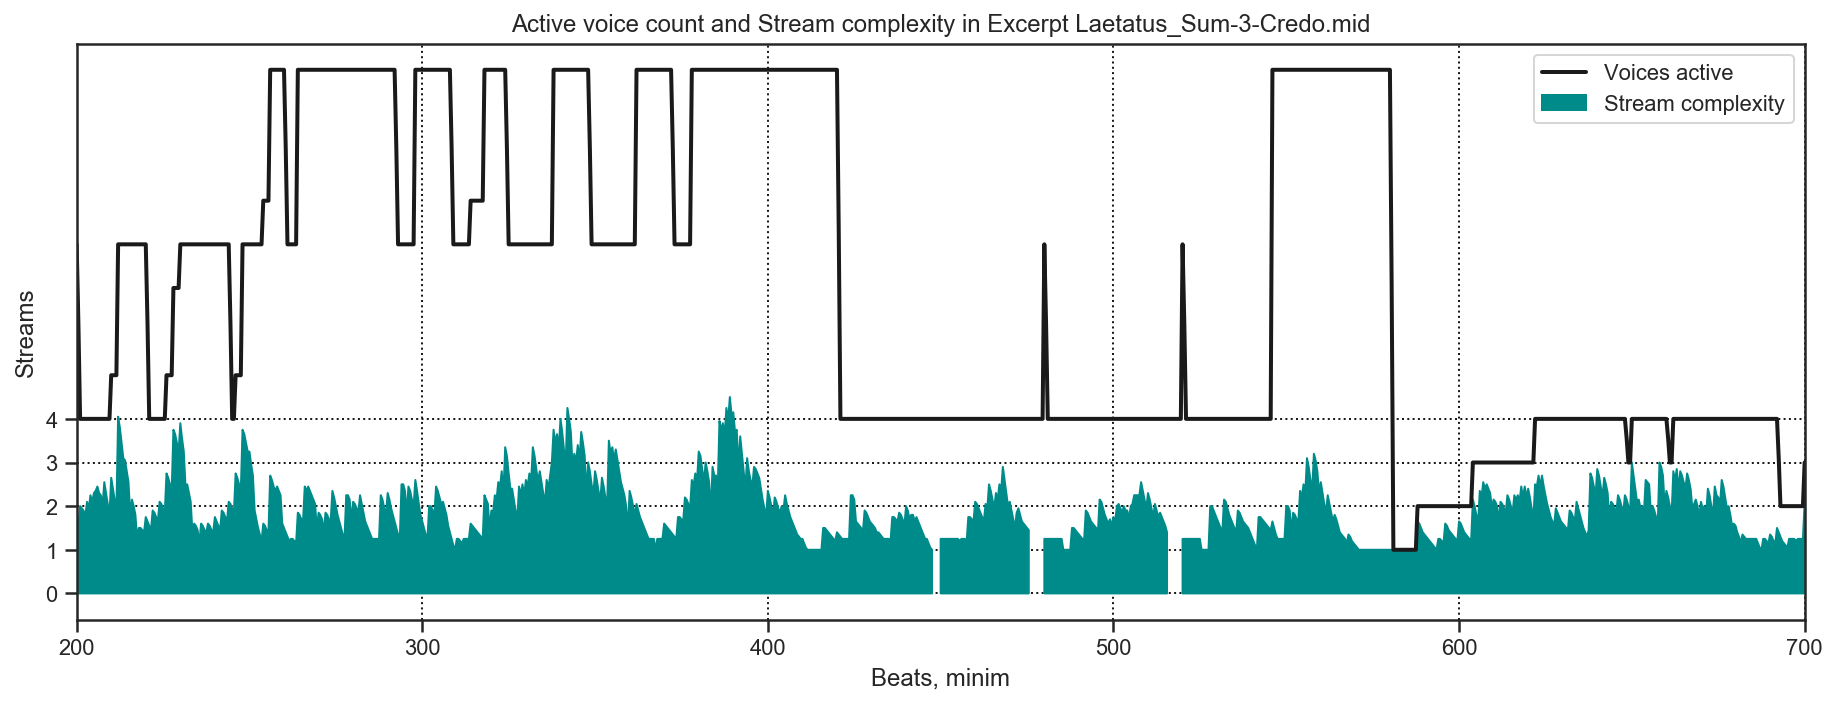

1.9325313807531381
4.55
7.249723087573555
1444.0


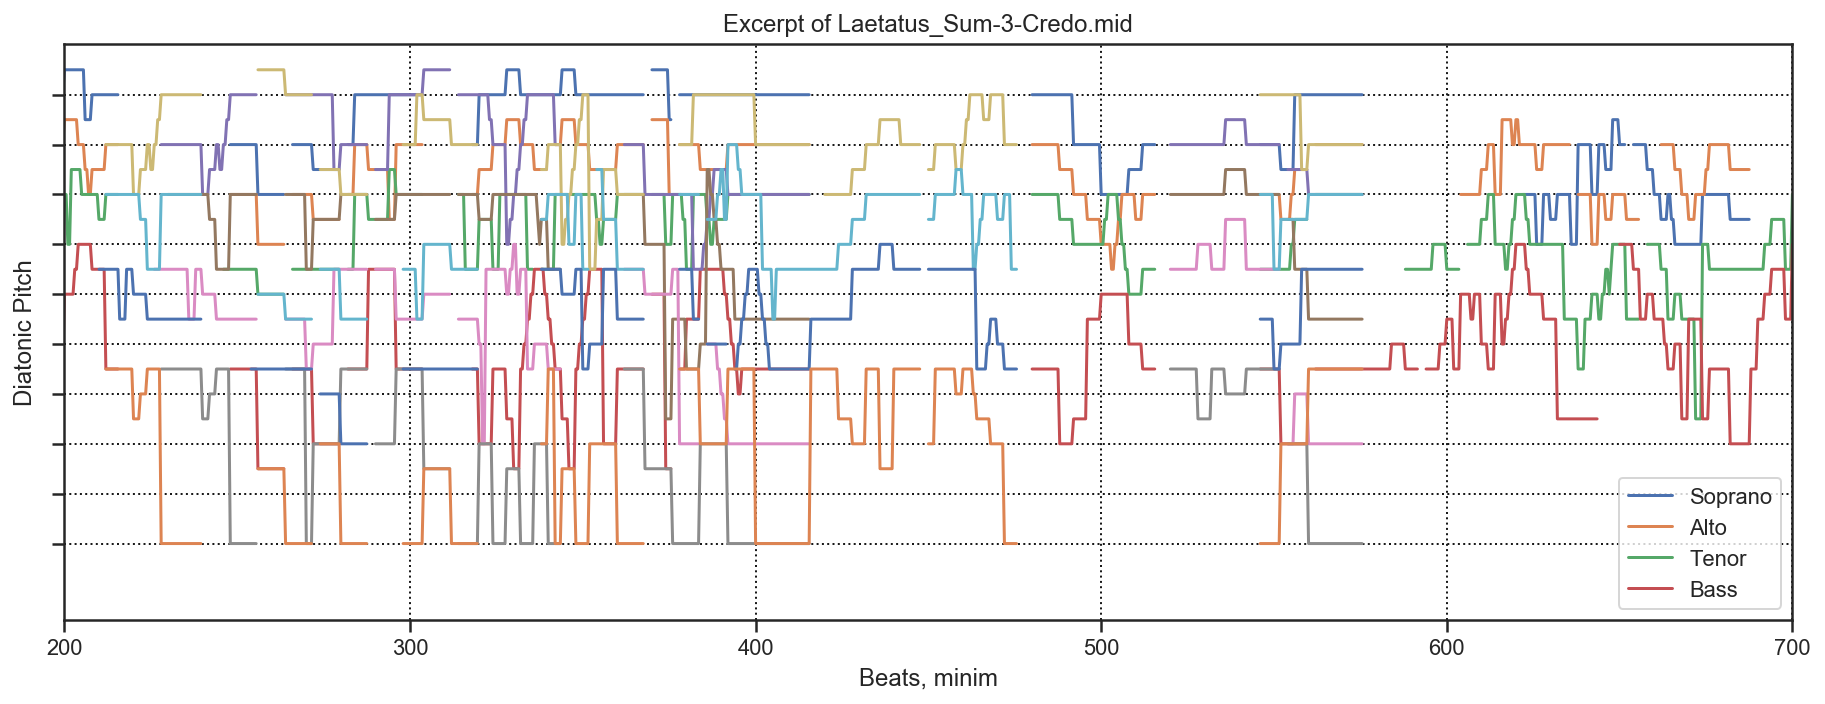

In [16]:
# test the outputs of 
piece = 998

df_seperated = Counterpoint_seperated[piece]
A = Voices_counted[piece]
dets = df.loc[piece,:]
print(dets)

os.chdir('/Users/finn/Documents/DDMAL/Scores/masses_all/Victoria/')
score = m21.converter.parse(dets.file)
df_pitchs = Score_Pitch_Steps(score)

x_r = np.array([200,700])
os.chdir('/Users/finn/Documents/DDMAL/dev/complexity/masses')



fig= plt.figure(figsize=(15,5))
axes= fig.add_axes([0.1,0.1,0.8,0.8])
axes.plot(A,color="k",linewidth=2)
axes.fill_between(df_seperated.index,df_seperated,0,color="darkcyan")
axes.set_xbound(lower=x_r[0], upper=x_r[1])
locs, labels = plt.yticks(np.arange(0, 5, step=1))
plt.grid(color='k', linestyle=':', linewidth=1)
plt.xlabel('Beats, minim')
plt.ylabel('Streams')
axes.legend(('Voices active', 'Stream complexity'))
plt.title('Active voice count and Stream complexity in Excerpt ' + dets.file)
plt.show()

print(df_seperated.mean())
print(df_seperated.max())
print(A.mean())
print(A.index[-1])

fig= plt.figure(figsize=(15,5))
axes= fig.add_axes([0.1,0.1,0.8,0.8])
axes.plot(df_pitchs)
step = np.min(np.diff(df_pitchs.index))
plt.grid(color='k', linestyle=':', linewidth=1)
axes.legend(('Soprano', 'Alto', 'Tenor','Bass'))
axes.yaxis.set_ticklabels([])
plt.xlabel('Beats, minim')
plt.ylabel('Diatonic Pitch')
plt.title('Excerpt of ' + dets.file)

axes.set_xbound(lower=x_r[0], upper=x_r[1])
locs, labels = plt.yticks(np.arange(25, 44, step=2))
plt.show()

# summary statistics 

In [22]:
# retreive the last round of evaluations

os.chdir('/Users/finn/Documents/DDMAL/Scores')
f=open('Masses_CompSeries_Stream3_3.pkl','rb')
S_Complexities=pickle.load(f)
f.close()

MusicIndex = S_Complexities['MusicIndex']
Counterpoint_seperated = S_Complexities['Streaming_Complexity']
Voices_counted = S_Complexities['Voice_Counts']

os.chdir('/Users/finn/Documents/DDMAL/Scores/masses_all')
print(len(MusicIndex))
print(len(Counterpoint_seperated))
print(len(Voices_counted))



1051
1051
1051


In [23]:
# fd carries over values from previous analysis, including metadata on each movement.
df=pd.DataFrame(columns=['Mass','MassID','Mvnt','Composer','CompID','C_Mean','C_Max','file']) #,'V_Median','V_Max'])

# choose form of complexity summary series to evaluate
Comp_Type = 'Counterpoint Complexity'
SC=Counterpoint_seperated

# fd carries over values from previous analysis, including metadata on each movement.
central_Stat = []
max_Stat = []
for i in range(len(SC)):
    df_seperated = SC[i]
    central_Stat=np.nanmean(df_seperated)
    max_Stat=np.nanmax(df_seperated)
    df = df.append({'Mass':MusicIndex.Mass[i],'MassID':MusicIndex.MassID[i],
                    'Mvnt':MusicIndex.Mvnt[i],'Composer':MusicIndex.Composer[i],
                    'CompID':MusicIndex.CompID[i], 'C_Mean':central_Stat,'C_Max':max_Stat,'file':MusicIndex.file},ignore_index=True)


# choose form of complexity summary series to evaluate

Comp_Type = 'Voice Counts'
VC=Voices_counted

# fd carries over values from previous analysis, including metadata on each movement.
central_Stat = []
max_Stat = []

for i in range(len(VC)):
    df_seperated = VC[i]
    central_Stat.append(np.nanmean(df_seperated))
    max_Stat.append(np.nanmax(df_seperated))
len(central_Stat)
# add to df
df.insert(7, "V_Mean", central_Stat, True)
df.insert(8, "V_Max", max_Stat, True)
df[:10]


,Mass,MassID,Mvnt,Composer,CompID,C_Mean,C_Max,V_Mean,V_Max,file
0,Missa_In_myne_zin,Agr1001,Gloria,Alexander Agricola,Agr,1.840216,4.000000,3.050844,4.0,0 Agr1001a-Missa_In_myne_zin-Gloria.kr...
1,Missa_In_myne_zin,Agr1001,Credo,Alexander Agricola,Agr,1.721867,3.600000,3.138184,4.0,0 Agr1001a-Missa_In_myne_zin-Gloria.kr...
2,Missa_In_myne_zin,Agr1001,Sanctus,Alexander Agricola,Agr,1.824773,3.711111,3.032519,4.0,0 Agr1001a-Missa_In_myne_zin-Gloria.kr...
3,Missa_In_myne_zin,Agr1001,Agnus,Alexander Agricola,Agr,1.758435,3.544444,3.089096,4.0,0 Agr1001a-Missa_In_myne_zin-Gloria.kr...
4,Missa_Malheur_me_bat,Agr1004,Kyrie,Alexander Agricola,Agr,1.765599,3.850000,3.335535,4.0,0 Agr1001a-Missa_In_myne_zin-Gloria.kr...
5,Missa_Malheur_me_bat,Agr1004,Gloria,Alexander Agricola,Agr,1.607098,3.450000,3.142288,4.0,0 Agr1001a-Missa_In_myne_zin-Gloria.kr...
6,Missa_Malheur_me_bat,Agr1004,Credo,Alexander Agricola,Agr,1.641492,3.500000,3.312903,4.0,0 Agr1001a-Missa_In_myne_zin-Gloria.kr...
7,Missa_Malheur_me_bat,Agr1004,Sanctus,Alexander Agricola,Agr,1.548247,3.250000,2.832017,4.0,0 Agr1001a-Missa_In_myne_zin-Gloria.kr...
8,Missa_Malheur_me_bat,Agr1004,Agnus,Alexander Agricola,Agr,1.729867,3.600000,3.183663,4.0,0 Agr1001a-Missa_In_myne_zin-Gloria.kr...
9,Missa_Bergerette_savoysienne,Ano1001,Kyrie,Anonymus,Ano,1.575401,2.800000,3.204423,4.0,0 Agr1001a-Missa_In_myne_zin-Gloria.kr...


In [24]:
# reduce collection to relevant factors
# https://cmdlinetips.com/2018/02/how-to-subset-pandas-dataframe-based-on-values-of-a-column/

# Restrict Cycle movements 
print(len(df))
mainCycle = ['Kyrie','Gloria', 'Credo', 'Sanctus', 'Agnus']
cyc_df = df[df.Mvnt.isin(mainCycle)]
cyc_df = cyc_df.reset_index(drop = True)
print(len(cyc_df))

# drop those few with insufficient voices to be worth calculating around
cyc_df = cyc_df[cyc_df.V_Max>2] 
cyc_df = cyc_df.reset_index(drop = True)
print(len(cyc_df))


cyc_df['Composer'].value_counts()

1051
1051
1042


Giovanni Pierluigi da Palestrina    494
Pierre de la Rue                    124
Tomás Luis de Victoria               90
Unverified Josquin                   77
Josquin des Prez                     60
Johannes Ockeghem                    49
Johannes Martini                     38
Marbrianus de Orto                   25
Guillaume Du Fay                     20
Anonymus                             15
Obrecht                              11
Johannes Tinctoris                   10
Alexander Agricola                    9
Ludwig Daser                          5
Antoine de Fevin                      5
Pipelare                              5
Antoine Busnoys                       5
Name: Composer, dtype: int64

In [25]:
# Collects stats per mass cycle, df_cycles

# Cointerpoint complexity
Cycles = cyc_df.MassID.unique()
df_cycles = pd.DataFrame(columns=['Mass','MassID','Cycle_Mean','Cycle_Max','Composer'])
for mass in Cycles:
    mc = np.nanmean(cyc_df.loc[cyc_df['MassID'] == mass, 'C_Mean'])
    mc_m = np.nanmax(cyc_df.loc[cyc_df['MassID'] == mass, 'C_Max'])
    comps = cyc_df.loc[cyc_df['MassID'] == mass, 'Composer']
    massTitle = cyc_df.loc[cyc_df['MassID'] == mass, 'Mass']
    df_cycles = df_cycles.append({'Mass':massTitle.iloc[0],'MassID':mass,'Cycle_Mean':mc,'Cycle_Max':mc_m,'Composer':comps.iloc[0]},ignore_index=True)

# voice counts
central_Stat = []
max_Stat = []
for mass in Cycles:
    mc = np.nanmean(cyc_df.loc[cyc_df['MassID'] == mass, 'V_Mean'])
    mc_m = np.nanmax(cyc_df.loc[cyc_df['MassID'] == mass, 'V_Max'])
    central_Stat.append(mc)
    max_Stat.append(mc_m)
df_cycles.insert(5,'Voices_Mean', central_Stat, True)
df_cycles.insert(6,'Voices_Max', max_Stat, True)


In [26]:
os.chdir('/Users/finn/Documents/DDMAL/dev/complexity/masses')
# add the era range to the cycle stats.
df_EachMasse=pd.read_csv(r'MasseCycleList_3.csv')
os.chdir('/Users/finn/Documents/DDMAL/Scores/masses_all')

df_cycles['Era'] = df_EachMasse['quartile']
df_cycles['Composer'] = df_EachMasse['Composer']
df_cycles['Birth'] = df_EachMasse['Birth (c.)']
df_cycles['Death'] = df_EachMasse['Death']

print(df_cycles['Era'].value_counts())

K = cyc_df.MassID
for i in range(len(df_cycles)):
    mass = df_cycles.loc[i,'MassID']
    e = df_cycles.loc[i,'Era']
    K = K.mask(cyc_df['MassID'] == mass,e)

cyc_df.insert(10,'Era', K, True)

print(cyc_df['Era'].value_counts())

df_cycles

1576-1600    97
1501-1525    51
1476-1500    28
1551-1575    22
1450-1475    18
Name: Era, dtype: int64
1576-1600    477
1501-1525    244
1476-1500    129
1551-1575    107
1450-1475     85
Name: Era, dtype: int64


,Mass,MassID,Cycle_Mean,Cycle_Max,Composer,Voices_Mean,Voices_Max,Era,Birth,Death
0,Missa_In_myne_zin,Agr1001,1.786323,4.00,Alexander Agricola,3.077661,4.0,1476-1500,1445.0,1506.0
1,Missa_Malheur_me_bat,Agr1004,1.658461,3.85,Alexander Agricola,3.161281,4.0,1476-1500,1445.0,1506.0
2,Missa_Bergerette_savoysienne,Ano1001,1.600750,3.35,Anonymus,3.191342,4.0,1501-1525,NaN,NaN
3,Missa_Lardant_desir,Ano1025,1.537987,3.25,Anonymus,3.478662,4.0,1476-1500,NaN,NaN
4,Missa_Gross_senen,Ano1026,1.589893,4.00,Anonymus,3.054131,4.0,1450-1475,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
211,Missa_Salve,Vic1014,1.963118,4.30,Tomás Luis de Victoria,5.662462,8.0,1576-1600,1548.0,1611.0
212,Missa_Simile_Est_Regnum_Coelorum,Vic1015,1.908656,4.35,Tomás Luis de Victoria,4.259819,8.0,1576-1600,1548.0,1611.0
213,Missa_Surge_Propera,Vic1016,2.110458,4.55,Tomás Luis de Victoria,4.313021,6.0,1576-1600,1548.0,1611.0
214,Missa_Trahe_Me_Post_Te,Vic1017,1.976672,4.60,Tomás Luis de Victoria,4.440891,6.0,1576-1600,1548.0,1611.0


In [27]:
# add era, numerical value in Time for linear regression
print(cyc_df['Era'].value_counts())
years = cyc_df.Era.unique()
print(years)
eras = ['1450-1475', '1476-1500','1501-1525', '1526-1550', '1551-1575', '1576-1600']

df_Time = cyc_df['V_Max']

for i in range(len(eras)):
    print(eras[i])
    df_Time = df_Time.mask(cyc_df['Era'] == eras[i],i)

df_Time
cyc_df.insert(11,'Time',df_Time,True)


1576-1600    477
1501-1525    244
1476-1500    129
1551-1575    107
1450-1475     85
Name: Era, dtype: int64
['1476-1500' '1501-1525' '1450-1475' '1551-1575' '1576-1600']
1450-1475
1476-1500
1501-1525
1526-1550
1551-1575
1576-1600


In [28]:
# generate stats relative to the mass cycle in cyc_df

RelComp = []
for i in range(len(cyc_df)):
    a = float(cyc_df.loc[i, 'C_Mean'] - df_cycles.loc[df_cycles['MassID'] == cyc_df.loc[i, 'MassID'],'Cycle_Mean'])
    RelComp.append(a)
cyc_df.insert(9,'C_R_Mean',RelComp,True)

RelComp = []
for i in range(len(cyc_df)):
    a = float(cyc_df.loc[i, 'C_Max'] - df_cycles.loc[df_cycles['MassID'] == cyc_df.loc[i, 'MassID'],'Cycle_Max'])
    RelComp.append(a)
cyc_df.insert(10,'C_R_Max',RelComp,True)

RelComp = []
for i in range(len(cyc_df)):
    a = float(cyc_df.loc[i, 'V_Mean'] - df_cycles.loc[df_cycles['MassID'] == cyc_df.loc[i, 'MassID'],'Voices_Mean'])
    RelComp.append(a)
cyc_df.insert(11,'V_R_Mean',RelComp,True)

RelComp = []
for i in range(len(cyc_df)):
    a = float(cyc_df.loc[i, 'V_Max'] - df_cycles.loc[df_cycles['MassID'] == cyc_df.loc[i, 'MassID'],'Voices_Max'])
    RelComp.append(a)
cyc_df.insert(12,'V_R_Max',RelComp,True)


cyc_df

,Mass,MassID,Mvnt,Composer,CompID,C_Mean,C_Max,V_Mean,V_Max,C_R_Mean,C_R_Max,V_R_Mean,V_R_Max,file,Era,Time
0,Missa_In_myne_zin,Agr1001,Gloria,Alexander Agricola,Agr,1.840216,4.000000,3.050844,4.0,0.053894,0.000000,-0.026817,0.0,0 Agr1001a-Missa_In_myne_zin-Gloria.kr...,1476-1500,1.0
1,Missa_In_myne_zin,Agr1001,Credo,Alexander Agricola,Agr,1.721867,3.600000,3.138184,4.0,-0.064456,-0.400000,0.060523,0.0,0 Agr1001a-Missa_In_myne_zin-Gloria.kr...,1476-1500,1.0
2,Missa_In_myne_zin,Agr1001,Sanctus,Alexander Agricola,Agr,1.824773,3.711111,3.032519,4.0,0.038450,-0.288889,-0.045142,0.0,0 Agr1001a-Missa_In_myne_zin-Gloria.kr...,1476-1500,1.0
3,Missa_In_myne_zin,Agr1001,Agnus,Alexander Agricola,Agr,1.758435,3.544444,3.089096,4.0,-0.027888,-0.455556,0.011435,0.0,0 Agr1001a-Missa_In_myne_zin-Gloria.kr...,1476-1500,1.0
4,Missa_Malheur_me_bat,Agr1004,Kyrie,Alexander Agricola,Agr,1.765599,3.850000,3.335535,4.0,0.107139,0.000000,0.174254,0.0,0 Agr1001a-Missa_In_myne_zin-Gloria.kr...,1476-1500,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1037,Missa_Vidi_Speciosam,Vic1018,Kyrie,Tomás Luis de Victoria,Vic,2.072297,4.150000,4.600927,6.0,0.060911,-0.400000,-0.446521,-1.0,0 Agr1001a-Missa_In_myne_zin-Gloria.kr...,1576-1600,5.0
1038,Missa_Vidi_Speciosam,Vic1018,Gloria,Tomás Luis de Victoria,Vic,1.789804,3.600000,4.988416,6.0,-0.221582,-0.950000,-0.059032,-1.0,0 Agr1001a-Missa_In_myne_zin-Gloria.kr...,1576-1600,5.0
1039,Missa_Vidi_Speciosam,Vic1018,Credo,Tomás Luis de Victoria,Vic,1.940759,3.900000,4.752179,6.0,-0.070627,-0.650000,-0.295269,-1.0,0 Agr1001a-Missa_In_myne_zin-Gloria.kr...,1576-1600,5.0
1040,Missa_Vidi_Speciosam,Vic1018,Sanctus,Tomás Luis de Victoria,Vic,2.027821,4.550000,4.588256,6.0,0.016435,0.000000,-0.459192,-1.0,0 Agr1001a-Missa_In_myne_zin-Gloria.kr...,1576-1600,5.0


In [29]:
# save these results from the last above cell
os.chdir('/Users/finn/Documents/DDMAL/Scores')
Summary_Streaming={'Cycle_stats':df_cycles,'Movement_stats':cyc_df,'Movements': mainCycle}
f=open('Masses_Comp_Summary_Stats_Stream_3.pkl','wb')
pickle.dump(Summary_Streaming,f,-1)
f.close()
os.chdir('/Users/finn/Documents/DDMAL/Scores/masses_all')